In [199]:
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pydse.arma import minic, ARMA
from pydse.utils import make_lag_arr
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [179]:
df_preCovid_train = pd.read_pickle("../Data/Subway_Data/preCovid_stdized_train.pkl")
df_preCovid_test = pd.read_pickle("../Data/Subway_Data/preCovid_stdized_test.pkl")
df_preCovid_full = pd.concat([df_preCovid_train, df_preCovid_test])
df_postCovid = pd.read_pickle("../Data/Subway_Data/postCovid_stdized.pkl")
df_all =  pd.concat([df_preCovid_full, df_postCovid])

In [180]:
df_preCovid_train.head(2)

,entries,entries_scaled
date,,
2015-01-03,2682846.0,-1.703944
2015-01-04,2481666.0,-1.877997


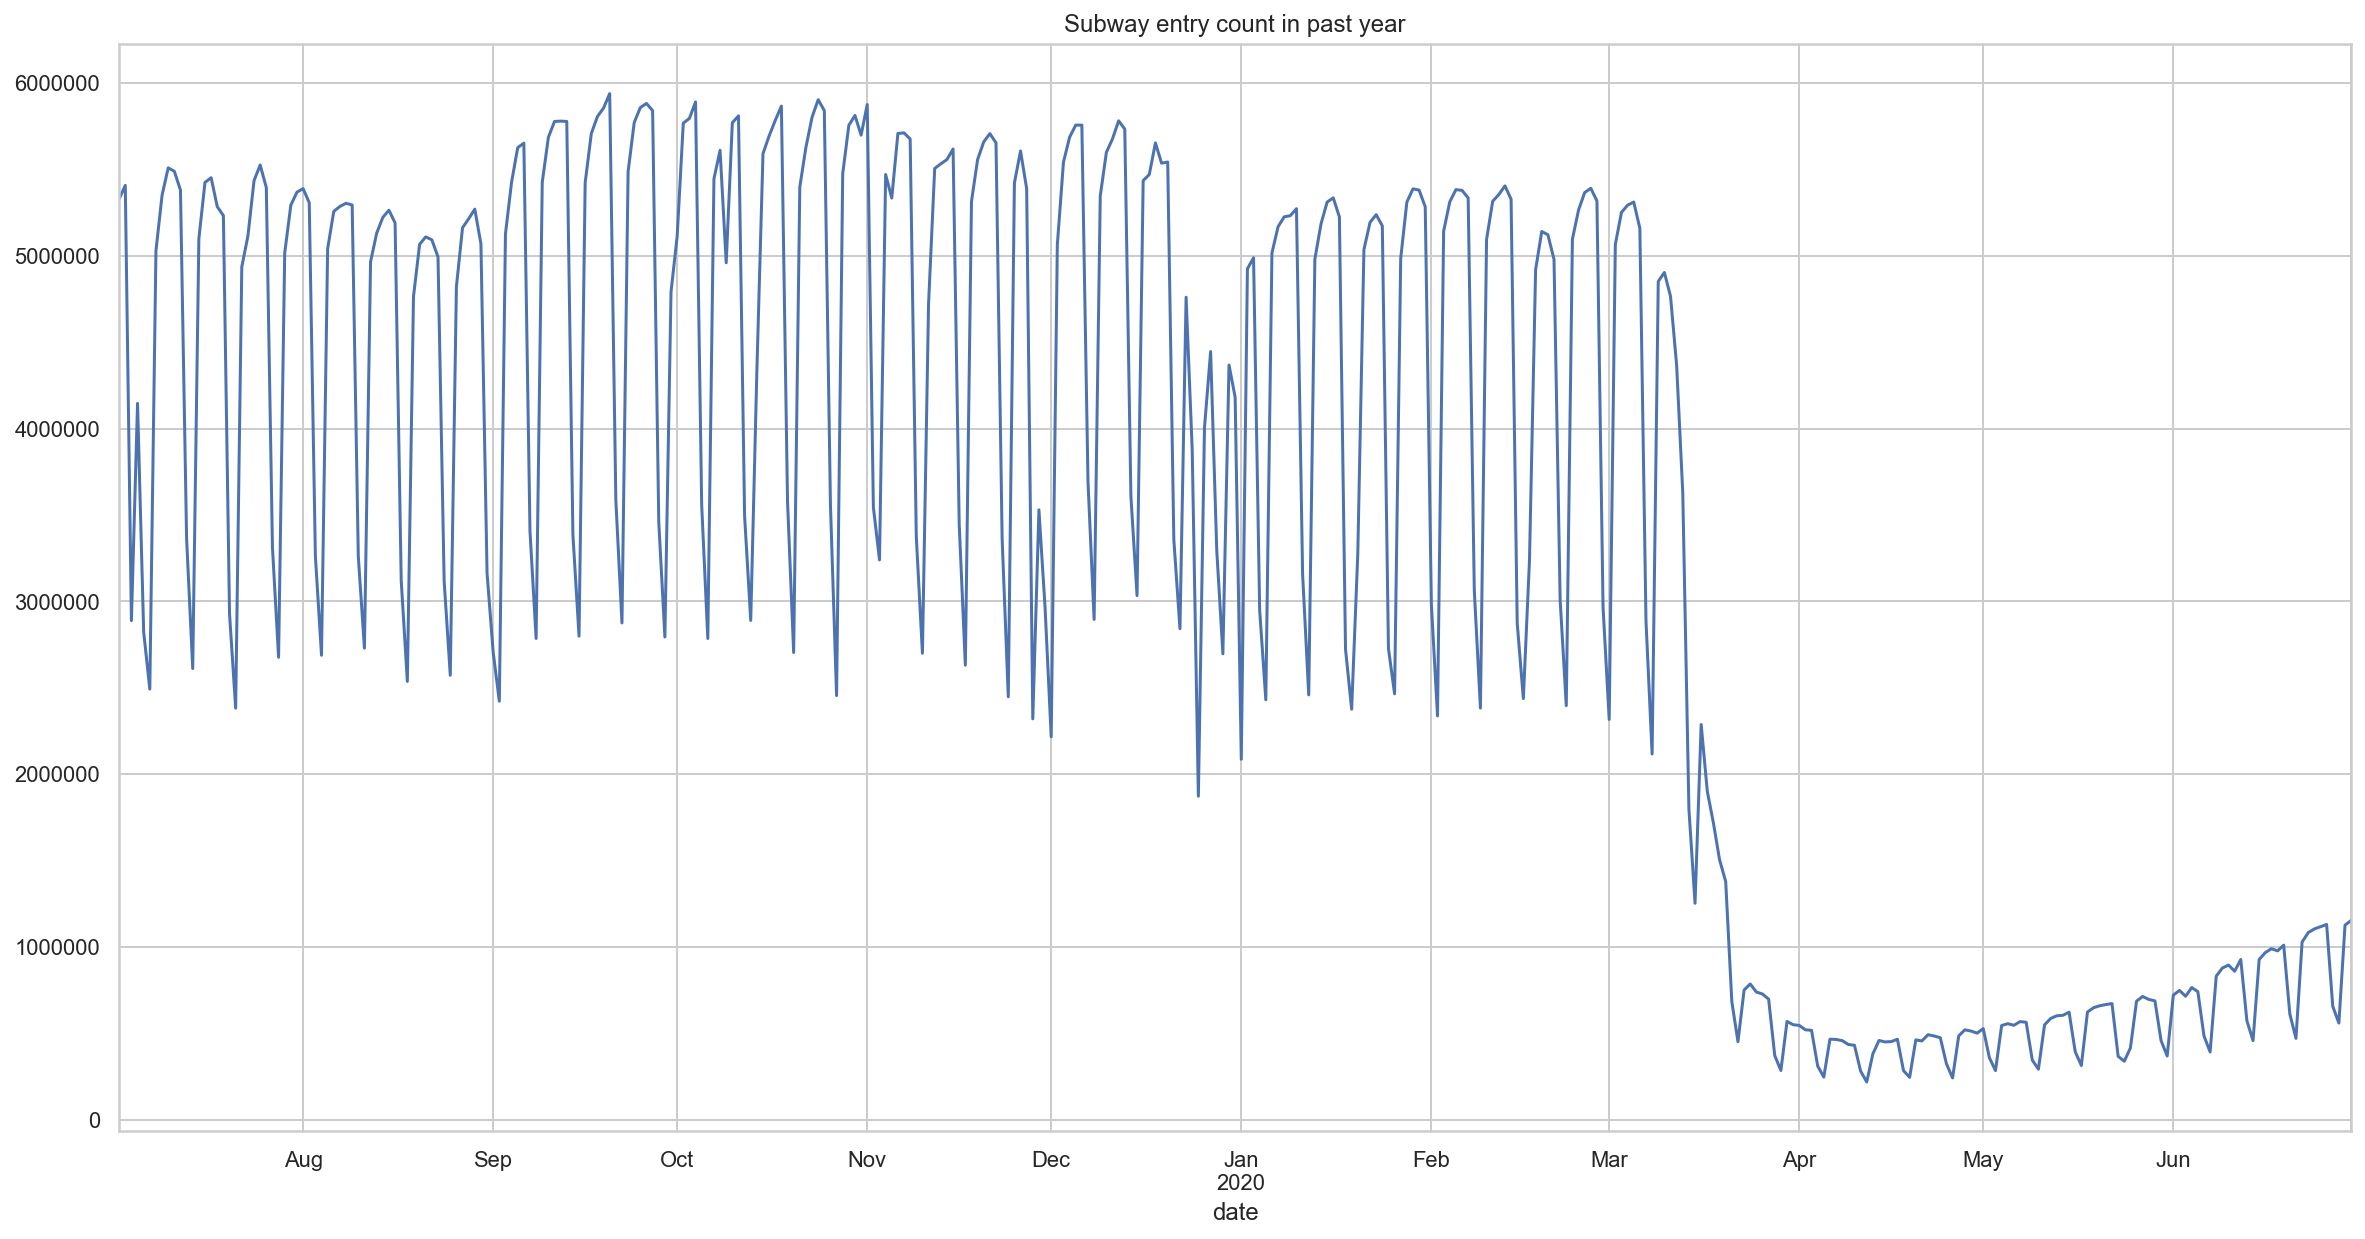

In [181]:
plt.figure(figsize=(20,10))
plt.title("Subway entry count in past year")
df_all["entries"][-365:].plot()
plt.show()

## Find gaps in timeseries

In [182]:
def find_gaps(df):
    df.reset_index(inplace=True)
    df["timediff"] = (df['date'] - df['date'].shift(1)) / np.timedelta64(1, 'D')
    print(df['timediff'].value_counts())
    df.set_index('date', inplace=True)
    
    return df

In [183]:
df_all = find_gaps(df_all)

# only have 1 day interval so good

1.0    2005
Name: timediff, dtype: int64


## Add columns for year, month, day, weekday

In [184]:
def add_date_col(df):
    df['year'] = df.index.map(lambda x: x.year)
    df['month'] = df.index.map(lambda x: x.month)
    df['day'] = df.index.map(lambda x: x.day)
    df['weekday'] = df.index.map(lambda x:x.weekday())
    df.reset_index(inplace=True)
    
    df['timeindex'] = (df['date'] - pd.Timestamp('2015-01-03')) / np.timedelta64(1, 'D')
    
    print(df.head(2))
    
    return df

In [185]:
df_all = add_date_col(df_all)

        date    entries  entries_scaled  timediff  year  month  day  weekday  \
0 2015-01-03  2682846.0       -1.703944       NaN  2015      1    3        5   
1 2015-01-04  2481666.0       -1.877997       1.0  2015      1    4        6   

   timeindex  
0        0.0  
1        1.0  


## Data Split

In [186]:
df_preCovid_train = df_all[df_all.date < '2019-11-01']
df_tmp = df_all[~(df_all.date < '2019-11-01')]
df_preCovid_test = df_tmp[df_tmp.date < '2020-03-01']
df_postCovid = df_tmp[~(df_tmp.date < '2020-03-01')]
df_preCovid_all = df_all[df_all.date < '2020-03-01']

## Arima model
- not really good for non-stationary
- remove seasonality
- remove linear trend

### remove linear trend
- using only **df_preCovid_train**

In [187]:
def remove_lin_trend(df_train, df_test, df_full):
    
    X_train = np.c_[df_train['timeindex']]
    y_train = df_train['entries']
    
    X_full = np.c_[df_full['timeindex']]
    print(len(X_train), len(y_train), len(X_full))
    
    linreg = linear_model.LinearRegression()
    linreg.fit(X_train, y_train)    
    df_full['trend'] = linreg.predict(X_full)
    
    df_full.set_index('date', inplace=True)
    print(df_full.head(2))
    
    plt.figure(figsize=(20,10))
    plt.title("Subway entry count and linear trend")
    df_full["entries"][:730].plot()
    df_full["trend"][:730].plot()

    plt.legend(loc=2)
    plt.show()
    
    #detrend
    plt.figure(figsize=(20,10))
    df_full['entries_detrended'] = df_full['entries'] / df_full['trend']
    df_full['entries_detrended'][:730].plot()
    plt.show()
    
    return df_full

1763 1763 1884
              entries  entries_scaled  timediff  year  month  day  weekday  \
date                                                                         
2015-01-03  2682846.0       -1.703944       NaN  2015      1    3        5   
2015-01-04  2481666.0       -1.877997       1.0  2015      1    4        6   

            timeindex         trend  
date                                 
2015-01-03        0.0  4.687625e+06  
2015-01-04        1.0  4.687585e+06  


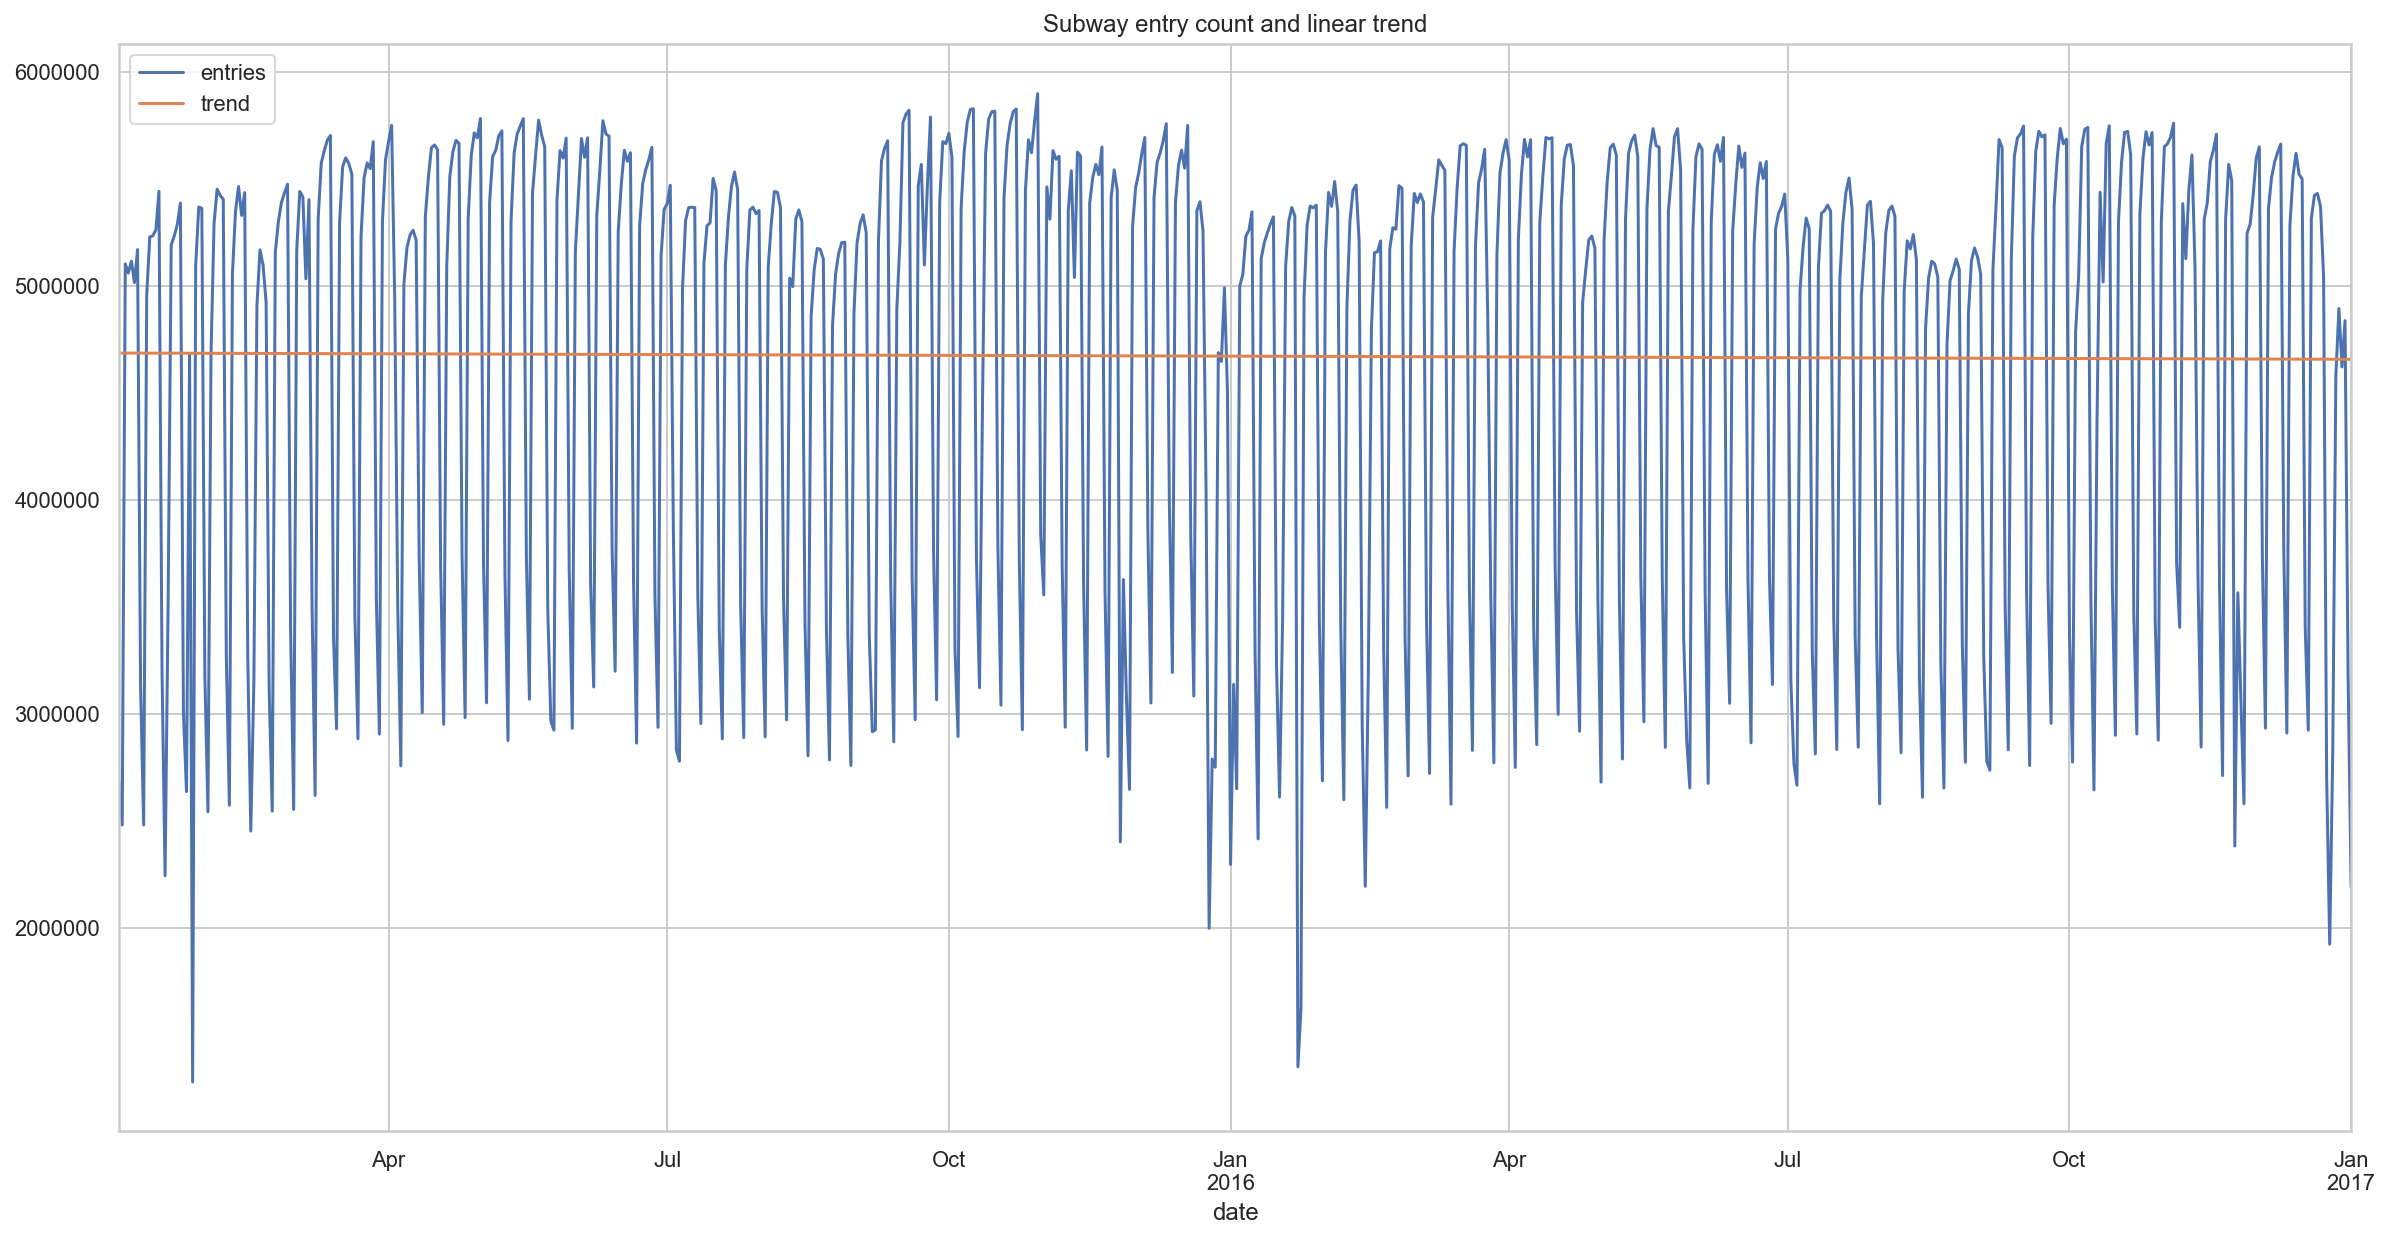

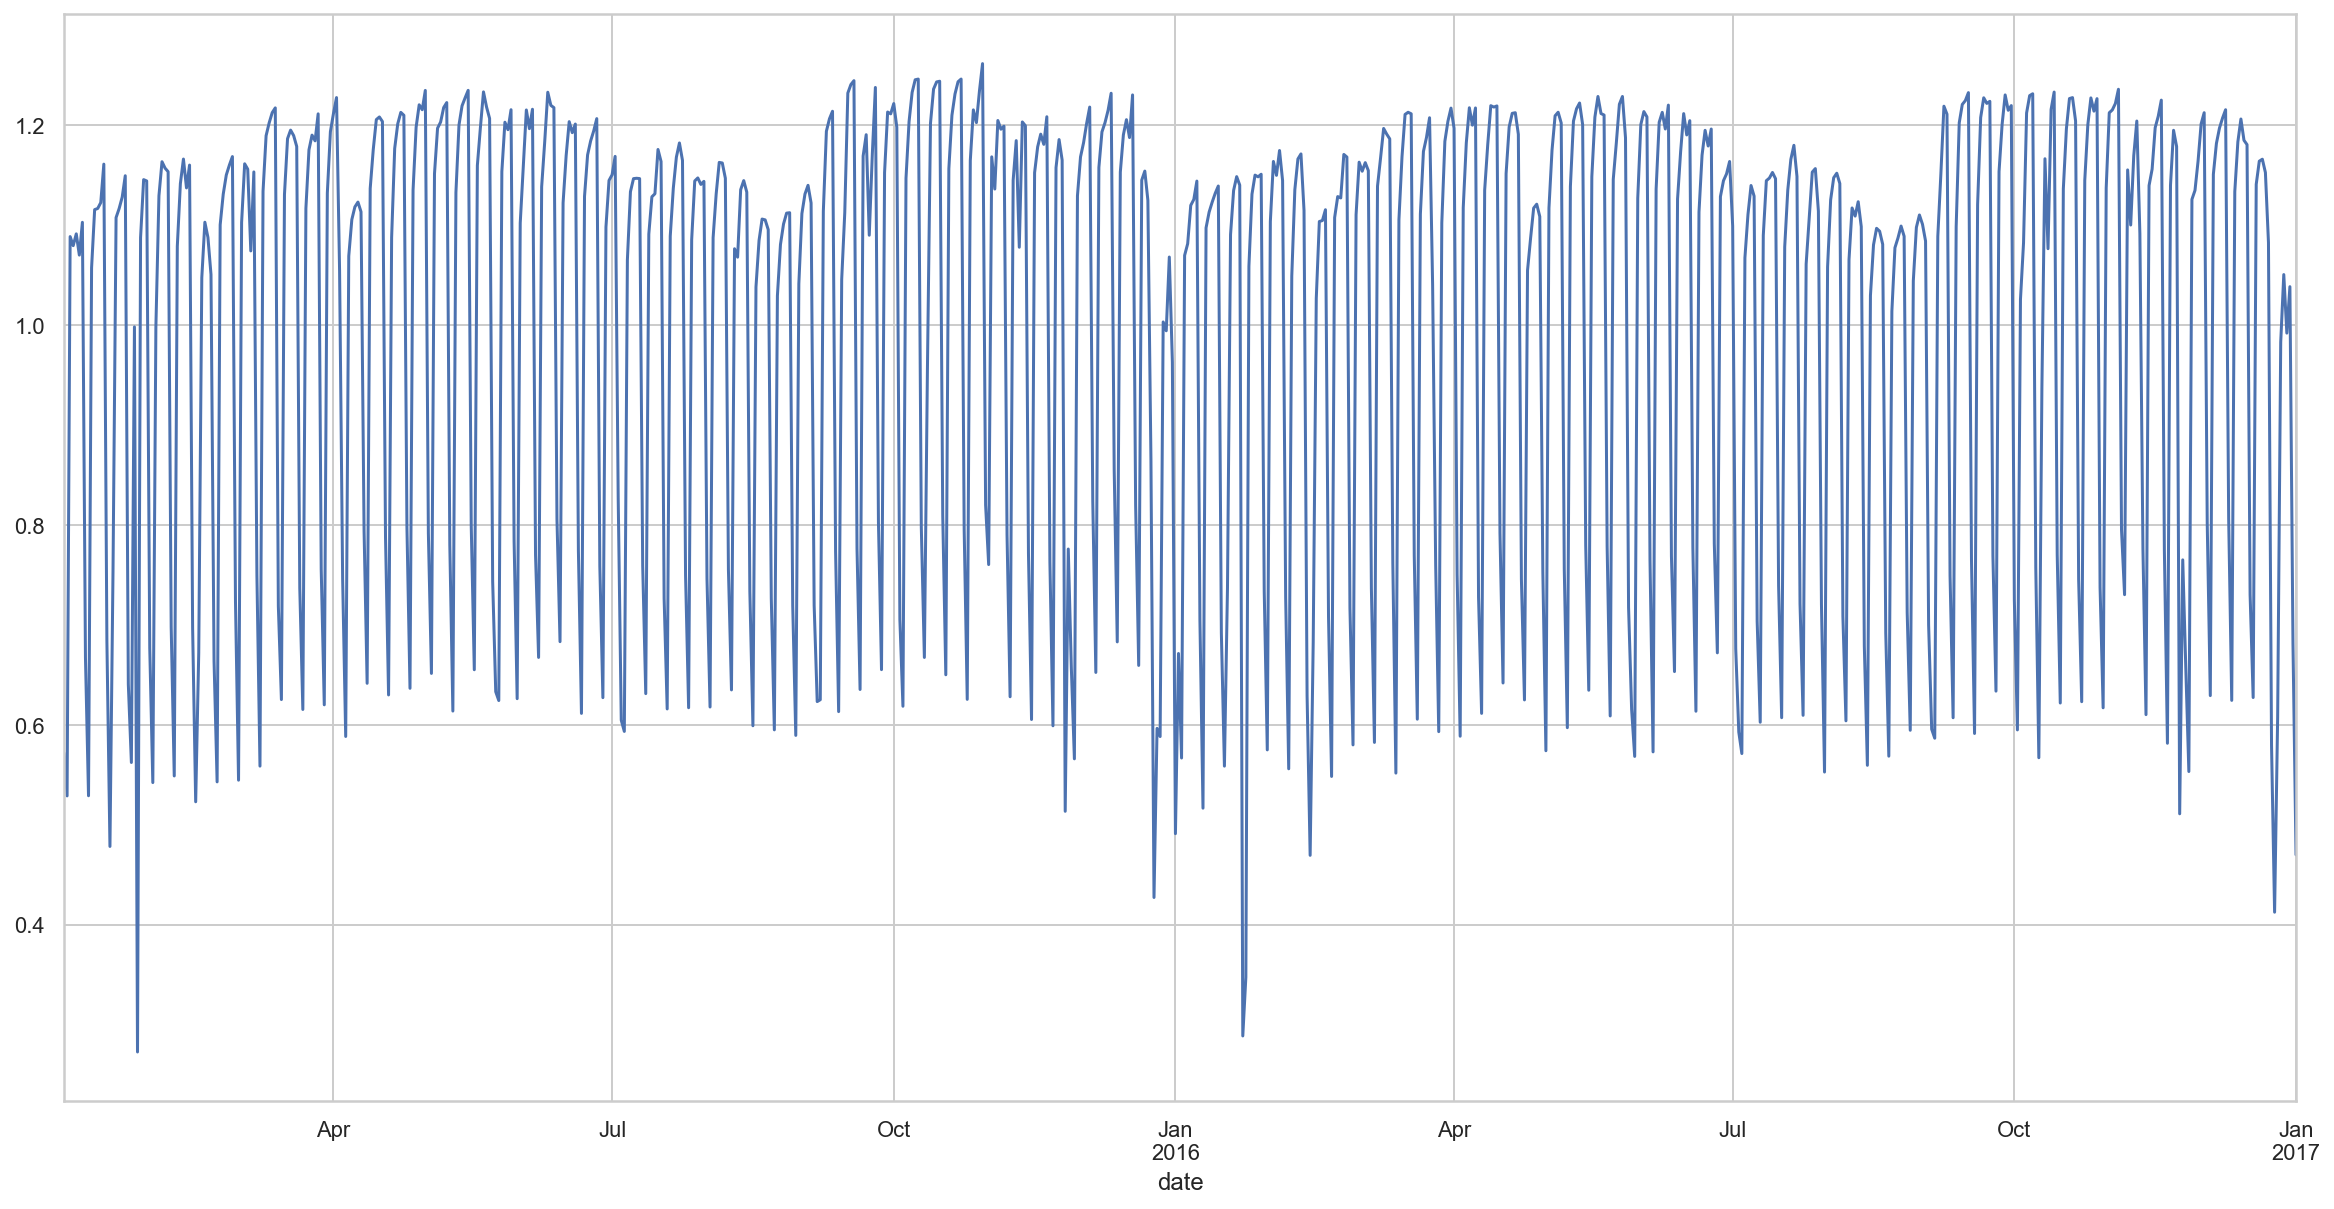

,entries,entries_scaled,timediff,year,month,day,weekday,timeindex,trend,entries_detrended
date,,,,,,,,,,
2015-01-03,2682846.0,-1.703944,NaN,2015,1,3,5,0.0,4.687625e+06,0.572325
2015-01-04,2481666.0,-1.877997,1.0,2015,1,4,6,1.0,4.687585e+06,0.529413


In [188]:
df_preCovid_all = remove_lin_trend(df_preCovid_train, df_preCovid_test, df_preCovid_all)
df_preCovid_all.head(2)

### Factor model

In [189]:
def remove_weekday_profile(row):
    return row['entries_detrended'] / weekday_factor[row['weekday']] 
def remove_month_profile(row):
    return row['entries_detrended_deweekdayed'] / month_factor[row['month']]
def factor_model(row):
    return row['trend'] * weekday_factor[row['weekday']] * month_factor[row['month']]

pred = f(trend) * f(weekday) * f(month)

In [190]:
def factor_model(df):
    weekday_factor = df.groupby('weekday')['entries_detrended'].mean().to_dict()
    df['entries_detrended_deweekdayed']  = df.apply(remove_weekday_profile, axis=1)
    month_factor = df_preCovid_all.groupby('month')['entries_detrended'].mean().to_dict()
    df['entries_detrended_deweekdayed_demonthed']  = df.apply(remove_month_profile, axis=1)
    
    #plot factored-out data
    plt.figure(figsize=(20,10))
    df['entries_detrended_deweekdayed_demonthed'][:730].plot()
    plt.show()
    
    return df

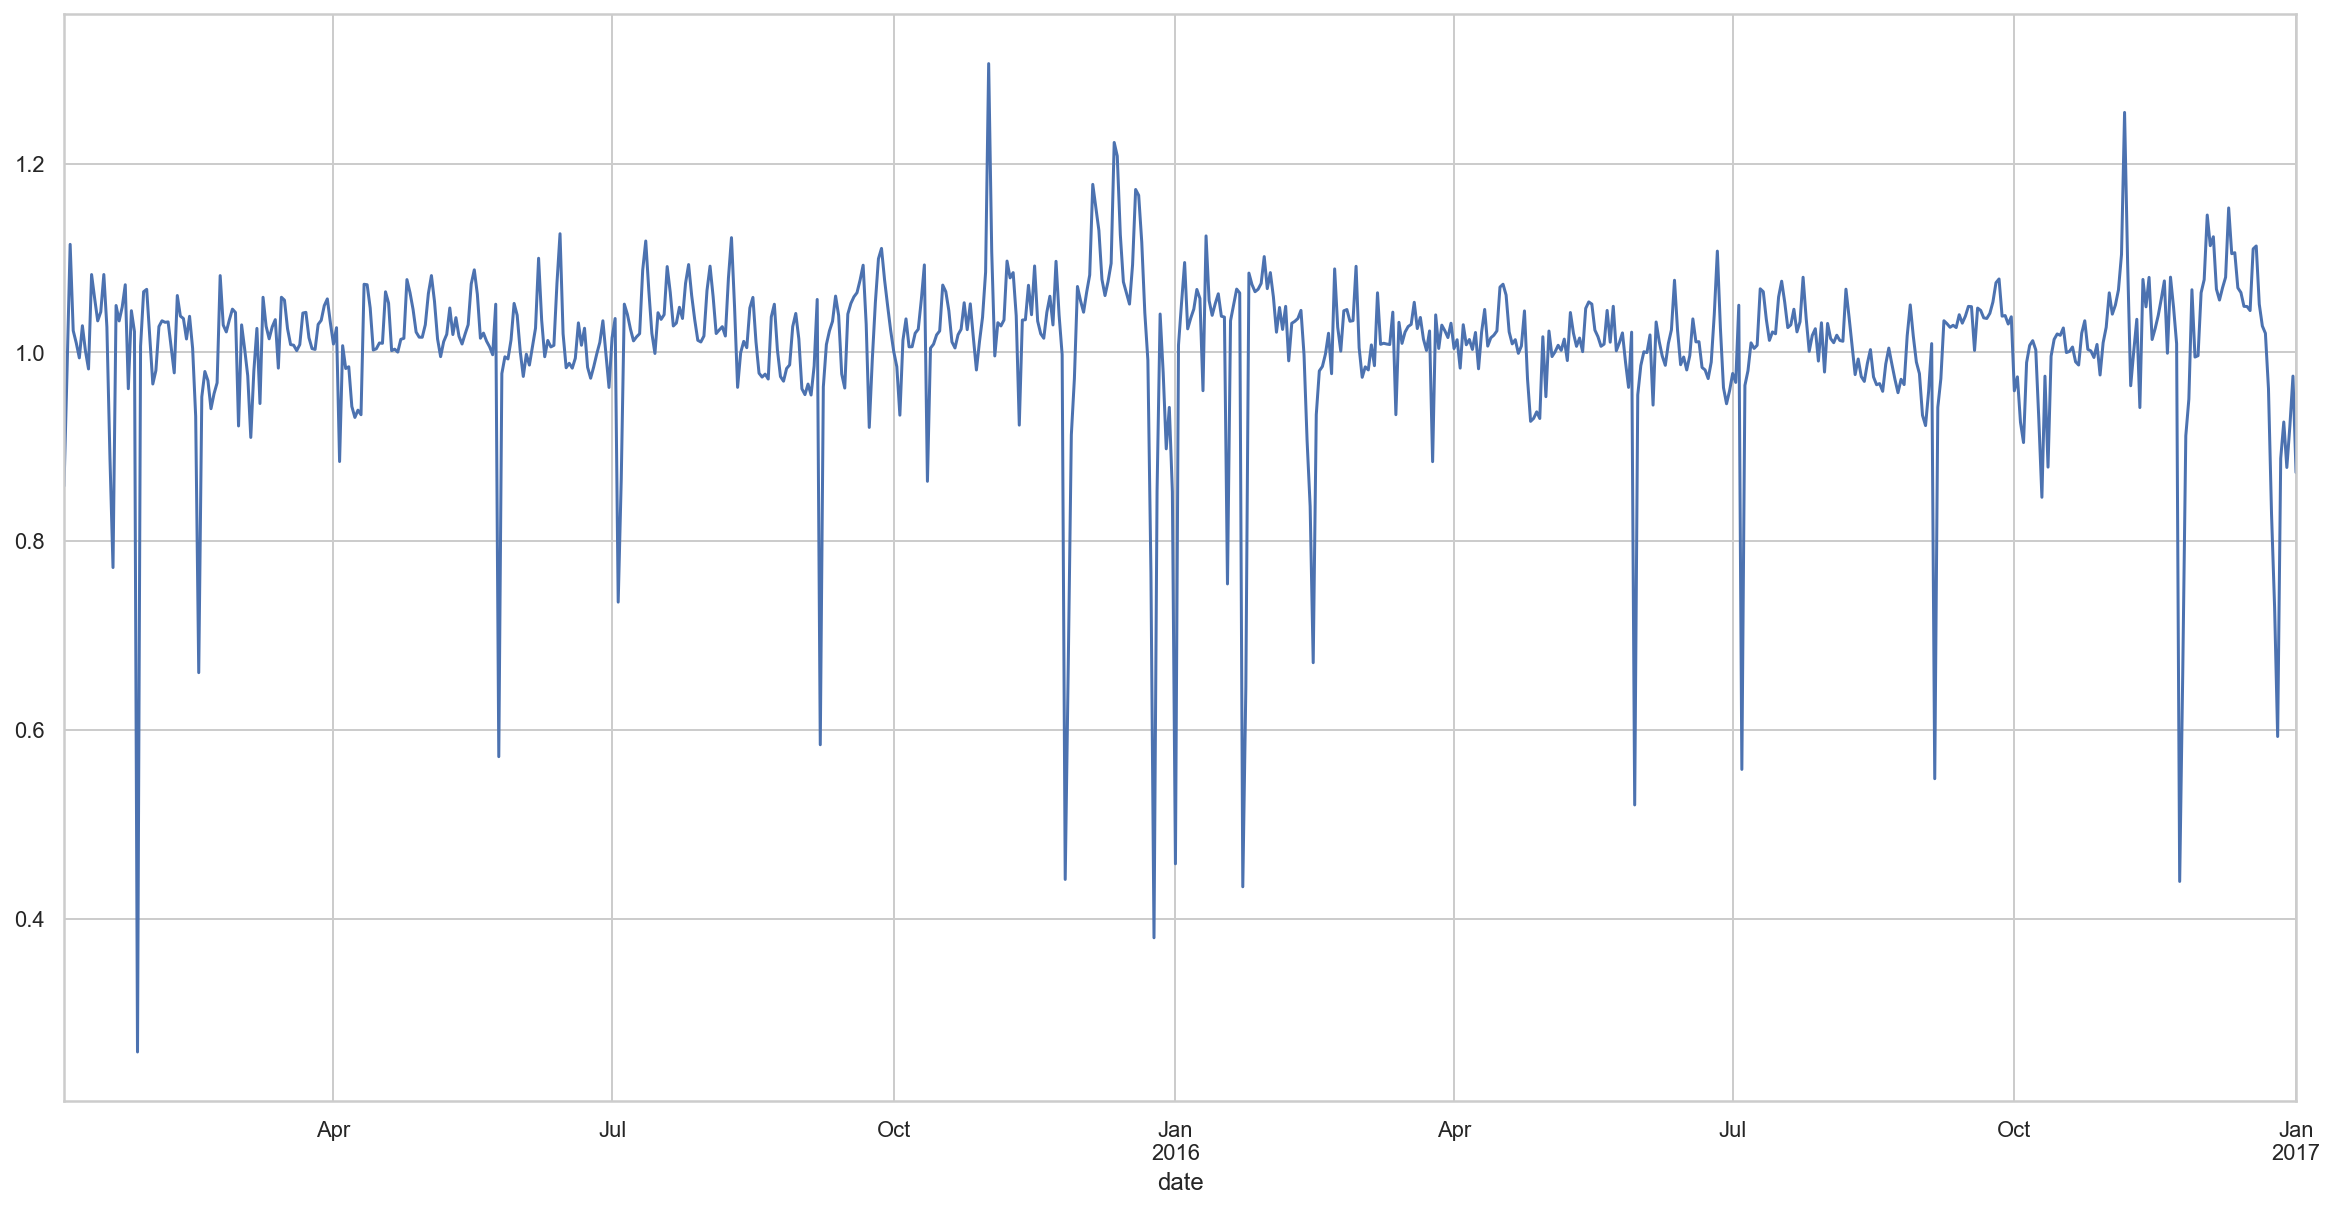

In [191]:
df_preCovid_all = factor_model(df_preCovid_all)

### Data Split

In [192]:
df_preCovid_train = df_preCovid_all[df_preCovid_all.index < '2019-11-01']
df_preCovid_test = df_preCovid_all[~(df_preCovid_all.index < '2019-11-01')]

In [193]:
def factor_model(row):
    return row['trend'] * weekday_factor[row['weekday']] * month_factor[row['month']]

In [194]:
df_preCovid_train['factor_model'] = df_preCovid_train.apply(factor_model, axis=1)
df_preCovid_test['factor_model'] = df_preCovid_test.apply(factor_model, axis=1)

In [195]:
df_preCovid_train.head()

,entries,entries_scaled,timediff,year,month,day,weekday,timeindex,trend,entries_detrended,entries_detrended_deweekdayed,entries_detrended_deweekdayed_demonthed,factor_model
date,,,,,,,,,,,,,
2015-01-03,2682846.0,-1.703944,NaN,2015,1,3,5,0.0,4.687625e+06,0.572325,0.794806,0.858439,3.125261e+06
2015-01-04,2481666.0,-1.877997,1.0,2015,1,4,6,1.0,4.687585e+06,0.529413,0.909391,0.982199,2.526643e+06
2015-01-05,5104111.0,0.390841,1.0,2015,1,5,0,2.0,4.687545e+06,1.088867,1.031871,1.114485,4.579795e+06
2015-01-06,5061648.0,0.354104,1.0,2015,1,6,1,3.0,4.687505e+06,1.079817,0.947288,1.023130,4.947220e+06
2015-01-07,5116883.0,0.401891,1.0,2015,1,7,2,4.0,4.687465e+06,1.091610,0.935098,1.009963,5.066405e+06


### standardize the data

In [196]:
scaler = StandardScaler()
scaler.fit(df_preCovid_train['factor_model'].values.reshape(-1,1))
print(scaler.mean_)
df_preCovid_train['pred_scaled'] = scaler.transform(df_preCovid_train['factor_model'].values.reshape(-1,1))
df_preCovid_test['pred_scaled'] = scaler.transform(df_preCovid_test['factor_model'].values.reshape(-1,1)) 

[4643363.59271957]


In [198]:
df_preCovid_train.head(2)

,entries,entries_scaled,timediff,year,month,day,weekday,timeindex,trend,entries_detrended,entries_detrended_deweekdayed,entries_detrended_deweekdayed_demonthed,factor_model,pred_scaled
date,,,,,,,,,,,,,,
2015-01-03,2682846.0,-1.703944,NaN,2015,1,3,5,0.0,4.687625e+06,0.572325,0.794806,0.858439,3.125261e+06,-1.427757
2015-01-04,2481666.0,-1.877997,1.0,2015,1,4,6,1.0,4.687585e+06,0.529413,0.909391,0.982199,2.526643e+06,-1.990750


### Evaluate

In [247]:
def mse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = mean_squared_error(y_actual, y_predicted)
    if print_val:
        print('MSE: {:,.4f}'.format(err))
    else:
        return err

def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Ridership Count', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     plt.xticks(actual.index.date[::7], 
#                actual.index.day[::7])
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)


In [206]:
def evaluate(pred, truth):
    mae = mean_squared_error(truth, pred)
    plt.figure(figsize=(20,10))
    plt.plot(pred, label='prediction')
    plt.plot(truth, label='truth')
    plt.title("MSE: {:.2f}".format(mae))
    plt.legend()
    plt.show()
    return mae

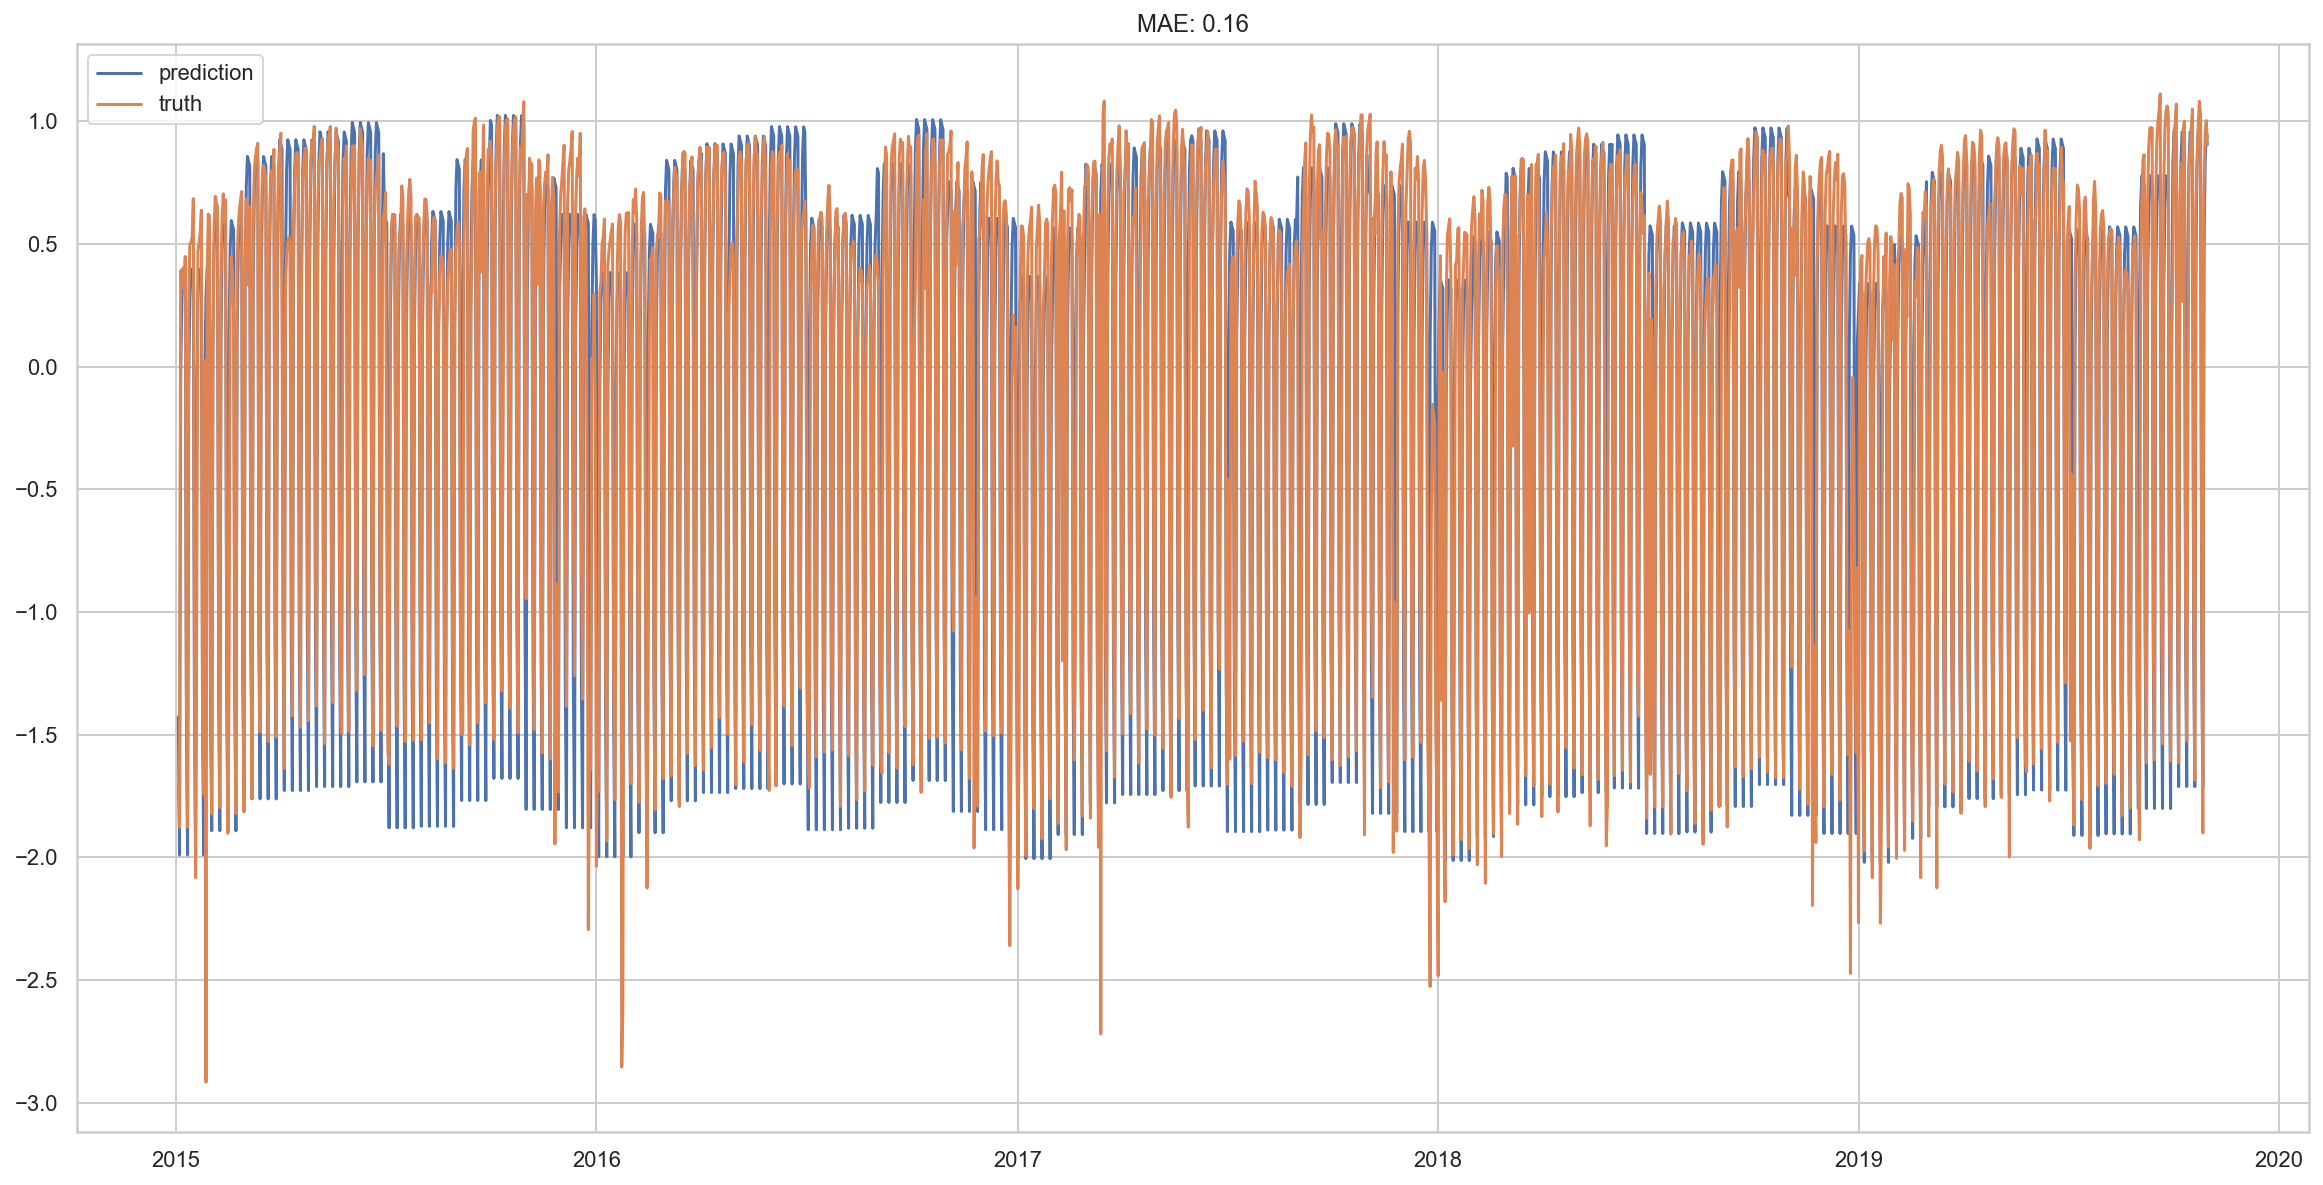

0.15914986906198034

In [207]:
evaluate(df_preCovid_train['pred_scaled'], df_preCovid_train['entries_scaled'])

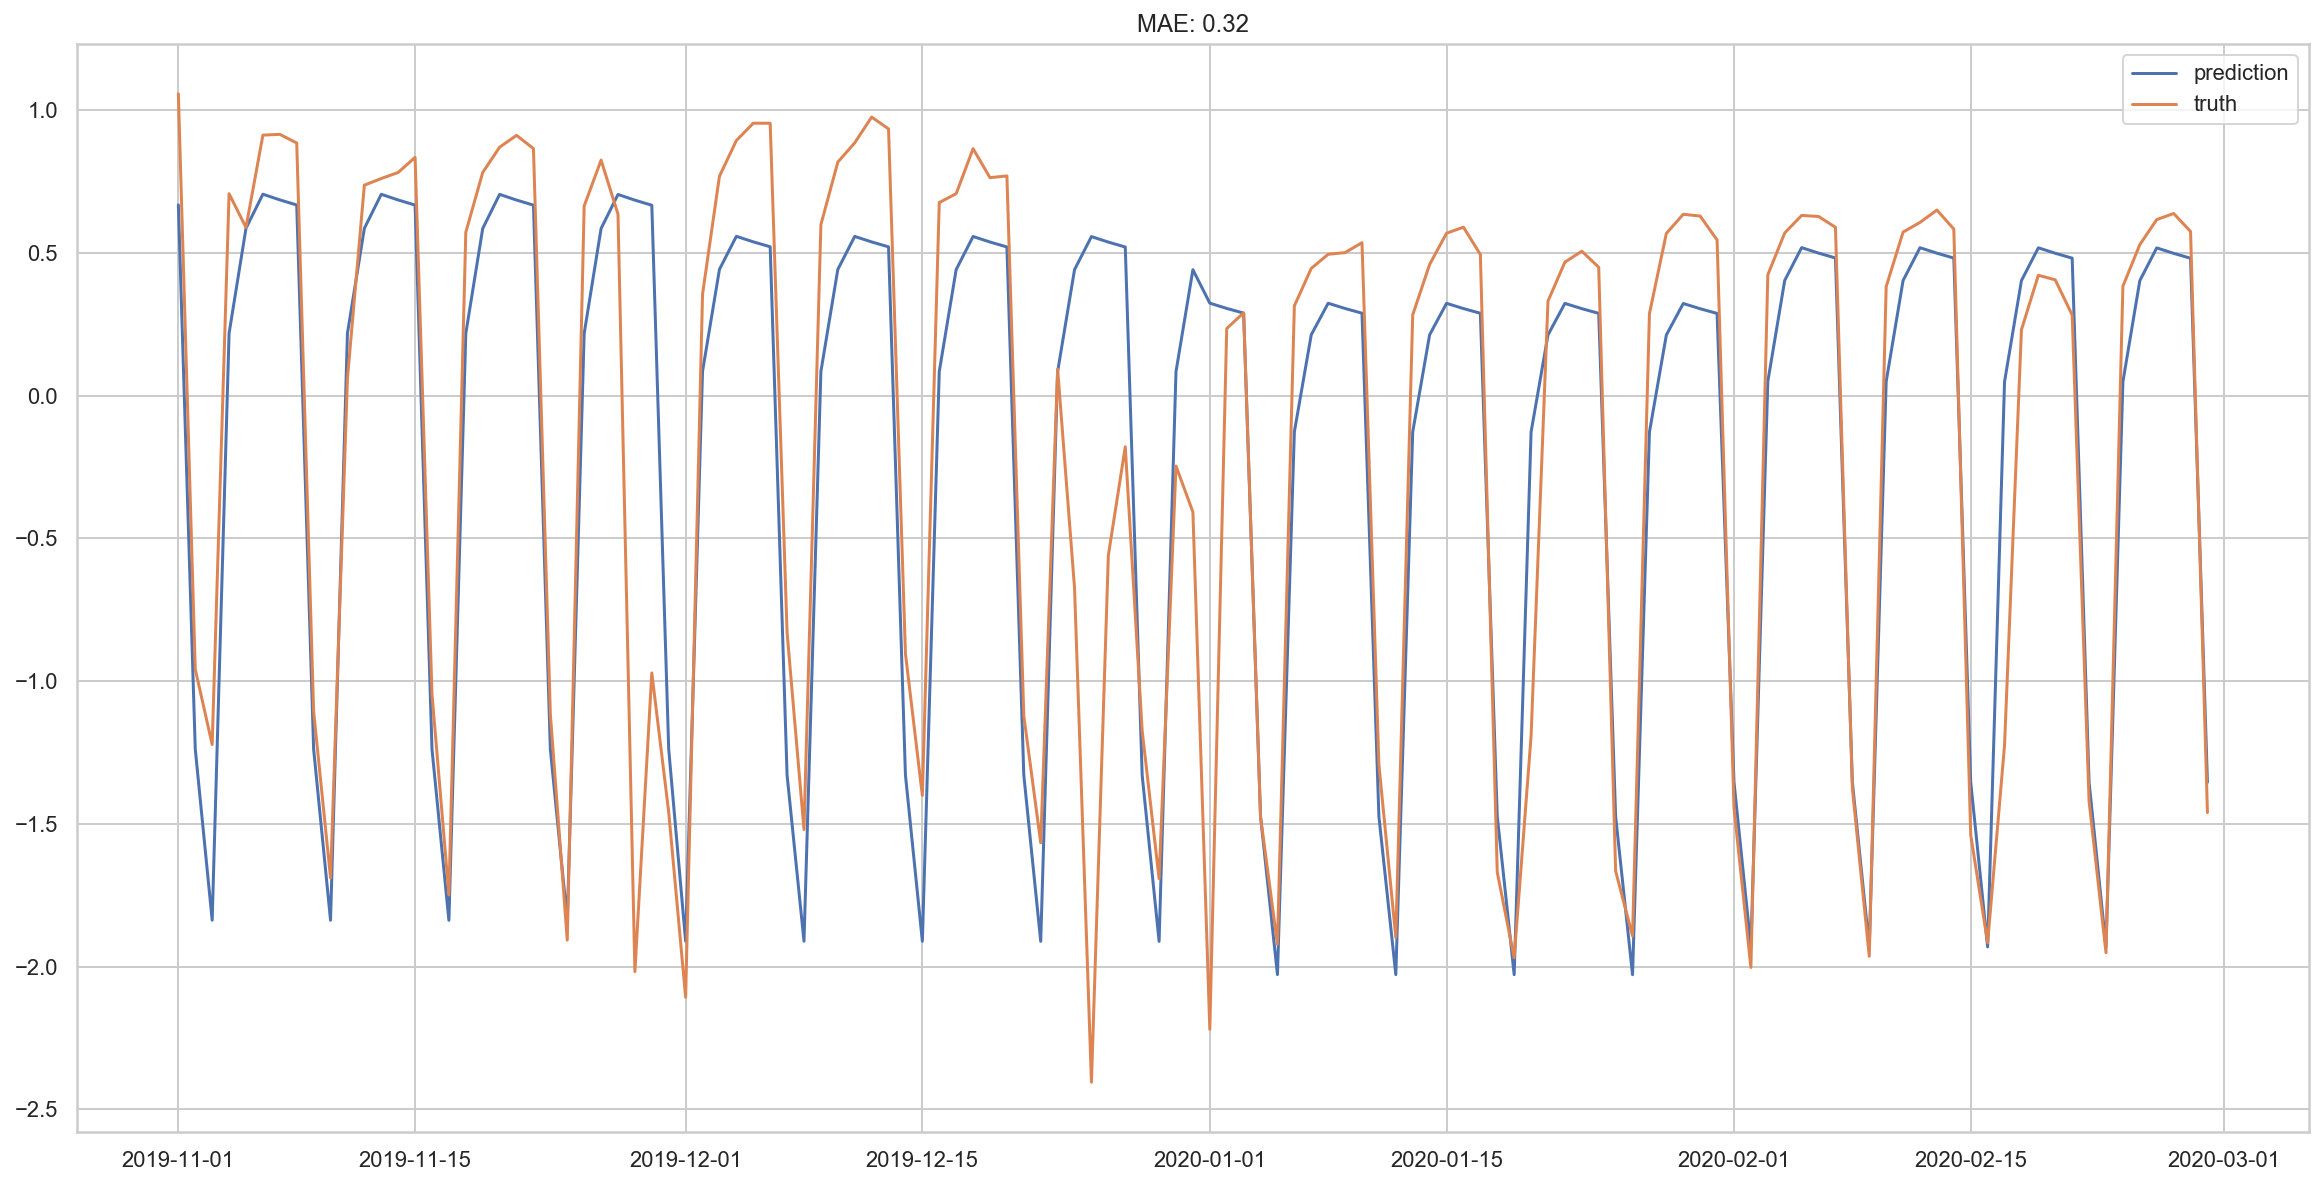

0.3233357127162111

In [208]:
evaluate(df_preCovid_test['pred_scaled'], df_preCovid_test['entries_scaled'])

## ARMA on residuals
- entries with detrended, deweekdayed, demonthed

In [211]:
df_preCovid_residual_train = df_preCovid_train[['entries_detrended_deweekdayed_demonthed']]
df_preCovid_residual_test = df_preCovid_test[['entries_detrended_deweekdayed_demonthed']]

In [213]:
df_preCovid_residual_train.head(2)

,entries_detrended_deweekdayed_demonthed
date,
2015-01-03,0.858439
2015-01-04,0.982199


In [214]:
#standardize residual
scaler = StandardScaler()
scaler.fit(df_preCovid_residual_train)
print(scaler.mean_)
df_preCovid_residual_train['residual_scaled'] = scaler.transform(df_preCovid_residual_train)
df_preCovid_residual_test['residual_scaled'] = scaler.transform(df_preCovid_residual_test) 

[1.0019623]


In [217]:
df_preCovid_residual_train.drop('entries_detrended_deweekdayed_demonthed', axis=1, inplace=True)
df_preCovid_residual_test.drop('entries_detrended_deweekdayed_demonthed', axis=1, inplace=True)

In [220]:
df_preCovid_residual_train.head(2)

,residual_scaled
date,
2015-01-03,-1.515937
2015-01-04,-0.208746


### Plot acf and pacf

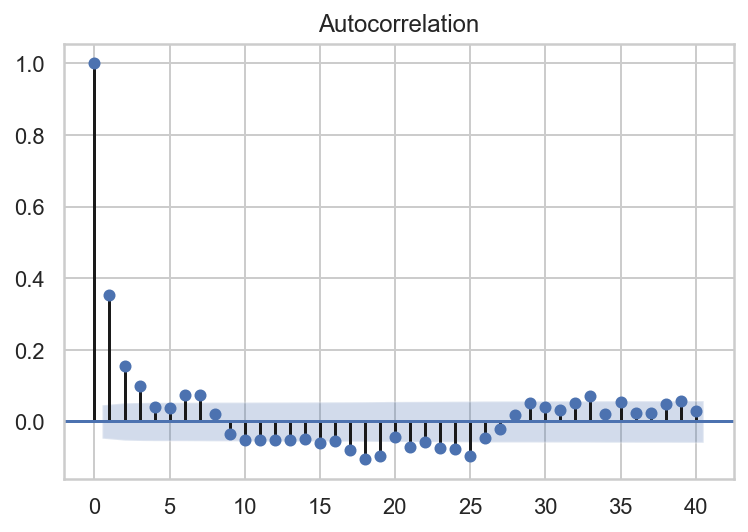

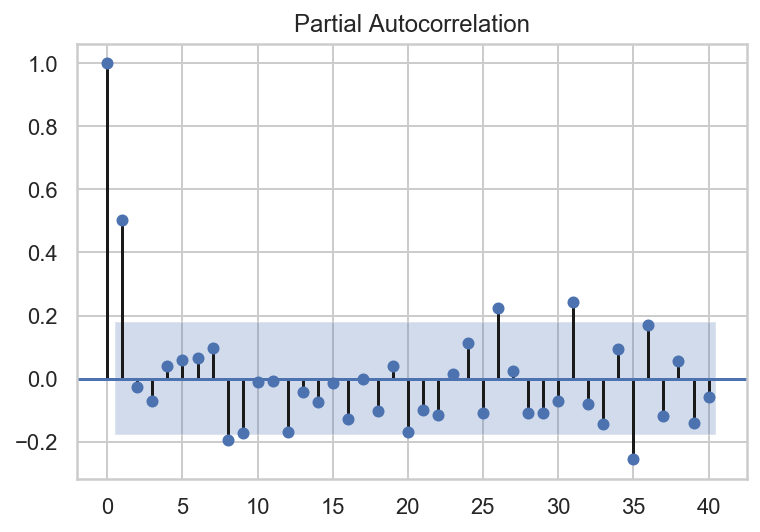

In [244]:
plot_acf(df_preCovid_residual_train, lags=40)
plt.show()

plot_pacf(df_preCovid_residual_test, lags=40)
plt.show()

### Find best AR and MA lags

In [150]:
best_ar_lags, best_ma_lags = minic([1], [1, 2, 3], residual_train, crit='AIC')
print(best_ar_lags, best_ma_lags)

(1,) (1, 2, 3)


### Fit ARMA(1,0) Model

/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


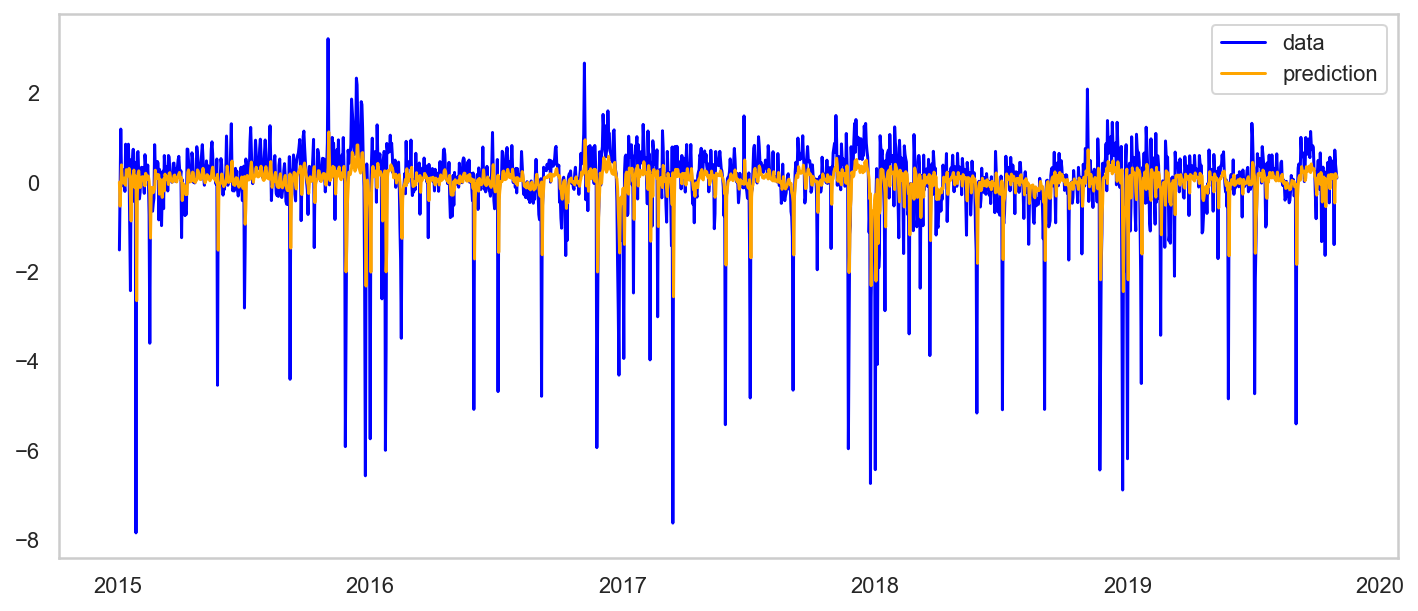

>>> mean_squared_error: 0.8737972299380392


In [259]:
from statsmodels.tsa.arima.model import ARIMA

df_preCovid_residual_train.index = pd.to_datetime(df_preCovid_residual_train.index )
arima = ARIMA(df_preCovid_residual_train, order=(1,0,1), freq='D')
arima_pred = arima.fit()
plt.figure(figsize=(12,5))
plt.plot(df_preCovid_residual_train, color='blue', label="data")
plt.plot(arima_pred.fittedvalues, color='orange', label="prediction")
plt.legend()
plt.grid()
plt.show()
print(f'>>> mean_squared_error: {mean_squared_error(df_preCovid_residual_train, arima_pred.fittedvalues)}')

,residual_scaled
date,
2015-01-03,-1.515937
2015-01-04,-0.208746
2015-01-05,1.188495
2015-01-06,0.223577
2015-01-07,0.084508
...,...
2019-10-27,-1.395985
2019-10-28,0.719368
2019-10-29,0.415128


MSE: 1.9796


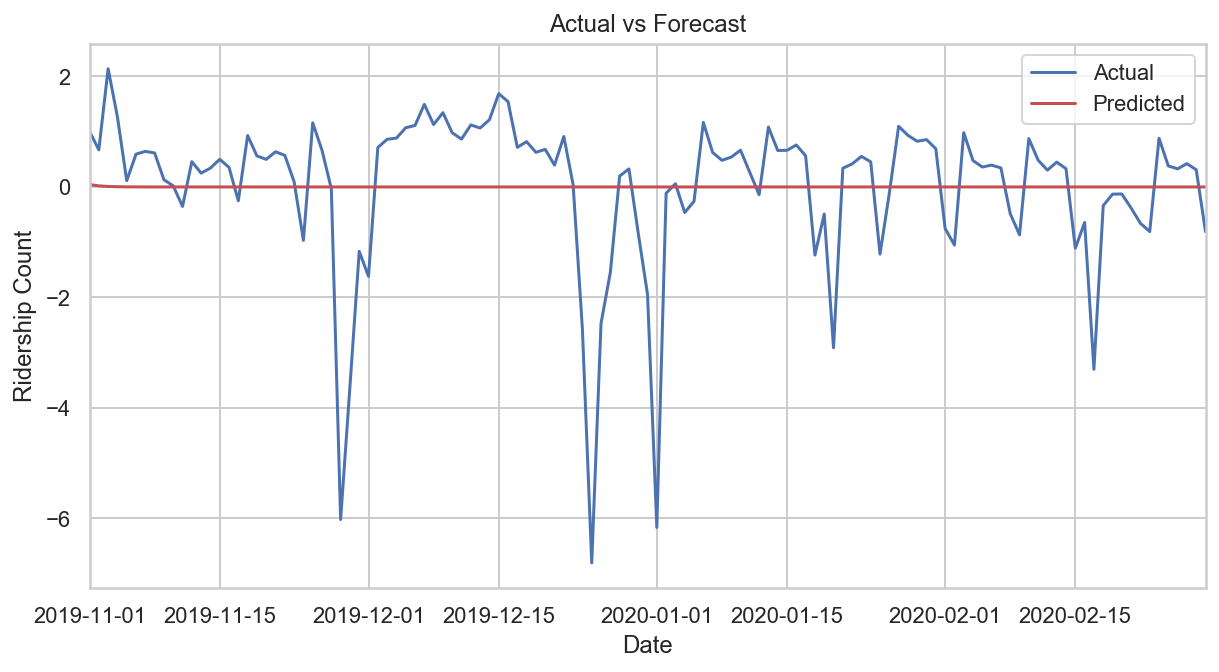

In [260]:
pred = arima_pred.predict(start='2019-11-01', end='2020-02-29') 
plot_forecast(df_preCovid_residual_test, pred)
mse(df_preCovid_residual_test, pred)

In [263]:
df_preCovid_residual_test

,residual_scaled
date,
2019-11-01,1.006110
2019-11-02,0.670434
2019-11-03,2.139468
2019-11-04,1.266737
2019-11-05,0.112600
...,...
2020-02-25,0.379494
2020-02-26,0.327460
2020-02-27,0.421316


In [262]:
pred

2019-11-01    0.043087
2019-11-02    0.019248
2019-11-03    0.008449
2019-11-04    0.003556
2019-11-05    0.001340
                ...   
2020-02-25   -0.000496
2020-02-26   -0.000496
2020-02-27   -0.000496
2020-02-28   -0.000496
2020-02-29   -0.000496
Freq: D, Name: predicted_mean, Length: 121, dtype: float64

In [255]:
postCovid_pred = arima_pred.predict(start=1, end=180) 

In [256]:
postCovid_pred

2015-01-04   -0.536172
2015-01-05   -0.132090
2015-01-06    0.387671
2015-01-07    0.119715
2015-01-08    0.042026
                ...   
2015-06-28    0.028422
2015-06-29    0.116039
2015-06-30   -0.001993
2015-07-01   -0.140491
2015-07-02    0.032530
Freq: D, Name: predicted_mean, Length: 180, dtype: float64

### Plot acf and pacf of new residual

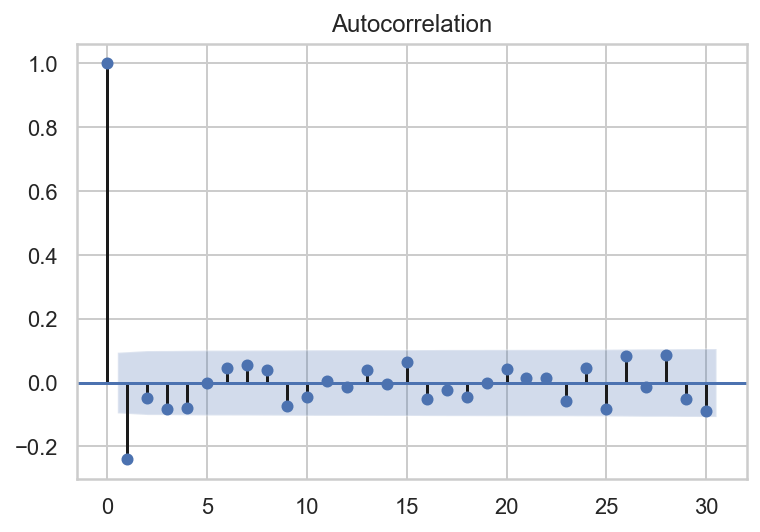

In [155]:
plot_acf(df_preCovid_test['pred_arma_residual'] - residual_test, lags=30)
plt.show()

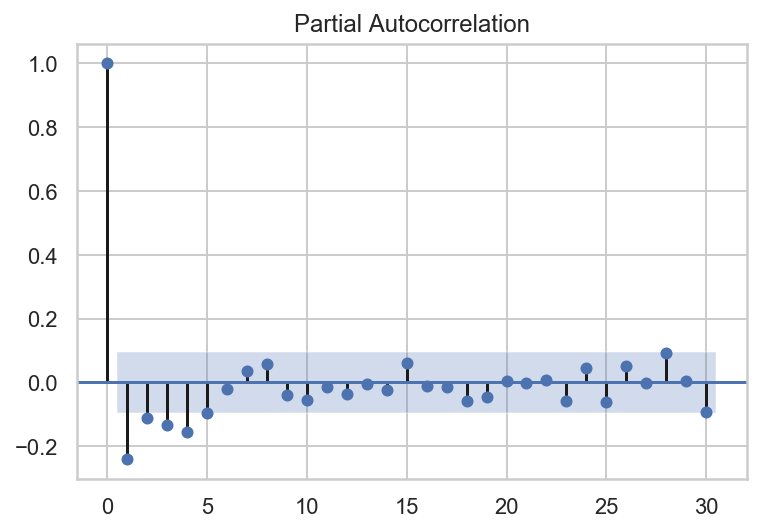

In [156]:
plot_pacf(df_preCovid_test['pred_arma_residual'] - residual_test, lags=30)
plt.show()

## SARIMAX

In [157]:
# Dataset
df_preCovid_train['lnEntries'] = np.log(df_preCovid_train['entries_diff'])

In [159]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(df_preCovid_train['lnEntries'] , order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                   D.DS12.lnEntries   No. Observations:                 1446
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -756.643
Date:                            Sun, 22 Nov 2020   AIC                           1521.285
Time:                                    21:29:50   BIC                           1542.392
Sample:                                01-16-2015   HQIC                          1529.163
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1397      0.039      3.618      0.000       0.064       0.215
ar.L2         -0.3361      0.027   